In [22]:
%load_ext lab_black

<IPython.core.display.Javascript object>

In [23]:
import pandas as pd
import numpy as np
from scipy.special import expit

<IPython.core.display.Javascript object>

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

<IPython.core.display.Javascript object>

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

<IPython.core.display.Javascript object>

In [26]:
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression

<IPython.core.display.Javascript object>

In [1]:
from weight_of_evidence import weight_of_evidence

In [28]:
import importlib

importlib.reload(weight_of_evidence)

<module 'weight_of_evidence' from '/Users/olivercairns/Desktop/code/WeightOfEvidenceDemo/weight_of_evidence.py'>

<IPython.core.display.Javascript object>

In [29]:
np.random.seed = 1234

<IPython.core.display.Javascript object>

In [30]:
company_age = np.arange(1, 100, 0.4)

<IPython.core.display.Javascript object>

In [31]:
def simulate_outcome(risk_vector):
    random_draws = np.random.uniform(size=risk_vector.shape)
    return (risk_vector > random_draws).astype(int)

<IPython.core.display.Javascript object>

In [32]:
linear_risk = expit((company_age - company_age.mean()) / company_age.std())

<IPython.core.display.Javascript object>

In [33]:
linear_outcome = simulate_outcome(linear_risk)

<IPython.core.display.Javascript object>

In [34]:
def discrete_fn(company_age):
    if company_age < 5:
        return 0.01
    elif company_age < 95:
        return 0.5
    else:
        return 0.99

<IPython.core.display.Javascript object>

In [35]:
def non_mono_fn(company_age):
    if company_age <= 25:
        return 0.25
    elif company_age <= 75:
        return 0.75
    else:
        return 0.25

<IPython.core.display.Javascript object>

In [36]:
discrete_vec = np.vectorize(discrete_fn)

<IPython.core.display.Javascript object>

In [37]:
non_mono_vec = np.vectorize(non_mono_fn)

<IPython.core.display.Javascript object>

In [38]:
discrete_risk = discrete_vec(company_age)

<IPython.core.display.Javascript object>

In [39]:
non_mono_risk = non_mono_vec(company_age)

<IPython.core.display.Javascript object>

In [40]:
SCENARIOS = [
    (linear_risk, "linear"),
    (discrete_risk, "discrete"),
    (non_mono_risk, "non-monotonic"),
]

<IPython.core.display.Javascript object>

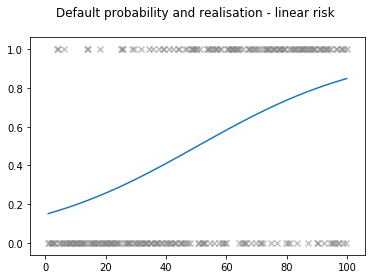

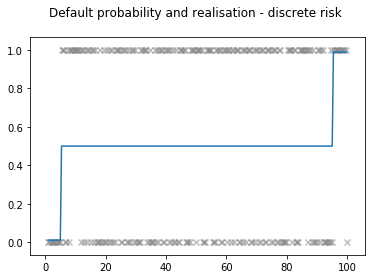

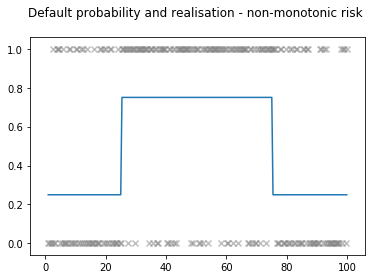

<IPython.core.display.Javascript object>

In [41]:
for risk_vector, plot_name in SCENARIOS:
    outcome = simulate_outcome(risk_vector)
    plt.plot(company_age, risk_vector)
    plt.scatter(company_age, outcome, marker="x", color="grey", alpha=0.5)
    plt.title(f"Default probability and realisation - {plot_name} risk \n")
    plt.show()

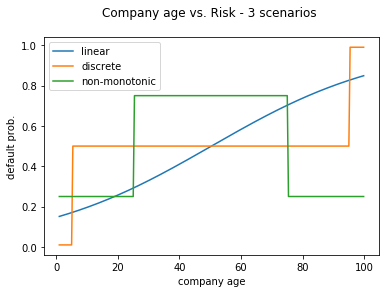

<IPython.core.display.Javascript object>

In [42]:
plt.plot(company_age, linear_risk)
plt.plot(company_age, discrete_risk)
plt.plot(company_age, non_mono_risk)
plt.legend(["linear", "discrete", "non-monotonic"])
plt.title("Company age vs. Risk - 3 scenarios \n")
plt.xlabel("company age")
plt.ylabel("default prob.")

plt.show()

In [43]:
log_reg = LogisticRegression(solver="lbfgs")

<IPython.core.display.Javascript object>

In [44]:
MODELS = (
    ("random forest", RandomForestClassifier()),
    ("log reg", LogisticRegression(solver="lbfgs")),
)

<IPython.core.display.Javascript object>

In [45]:
results = {"scenario": [], "auc": [], "model": []}
for risk_vector, scenario_name in SCENARIOS:
    for model_name, classifier in MODELS:
        for _ in range(10):
            y_train = simulate_outcome(risk_vector)
            y_test = simulate_outcome(risk_vector)
            X = np.array([company_age]).T
            classifier.fit(X, y_train)
            y_pred = classifier.predict_proba(X)[:, 1]
            auc = roc_auc_score(y_test, y_pred)
            results["scenario"].append(scenario_name)
            results["auc"].append(auc)
            results["model"].append(model_name)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


<IPython.core.display.Javascript object>

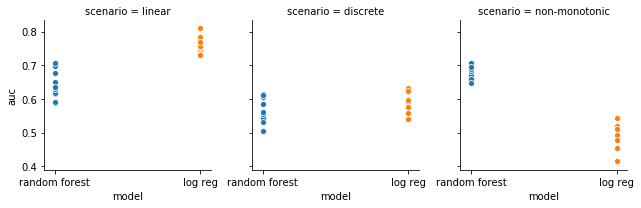

<IPython.core.display.Javascript object>

In [46]:
g = sns.FacetGrid(data=pd.DataFrame(results), col="scenario", hue="model")
g.map(sns.scatterplot, "model", "auc")

In [47]:
tree_binner = weight_of_evidence.TreeBinner(max_depth=2)

<IPython.core.display.Javascript object>

In [48]:
y_train = simulate_outcome(non_mono_risk)
y_test = simulate_outcome(non_mono_risk)

<IPython.core.display.Javascript object>

In [49]:
X = pd.DataFrame(data=X, columns=["company_age"])

<IPython.core.display.Javascript object>

In [50]:
y_train = pd.Series(y_train)

<IPython.core.display.Javascript object>

In [51]:
X_binned = tree_binner.fit_transform(X, y_train)

<IPython.core.display.Javascript object>

In [52]:
X_binned.company_age.unique()

array(['(-inf, 17.4]', '(17.4, 75.0]', '(75.0, inf]'], dtype=object)

<IPython.core.display.Javascript object>

In [53]:
woe_scaler = weight_of_evidence.WoeScaler()

<IPython.core.display.Javascript object>

In [54]:
X_scaled = woe_scaler.fit_transform(X_binned, y_train)

<IPython.core.display.Javascript object>

In [55]:
woe_scaler.woe_values_

{'company_age': {'(-inf, 17.4]': -1.6094379124341005,
  '(17.4, 75.0]': 0.7884573603642703,
  '(75.0, inf]': -1.2321436812926323}}

<IPython.core.display.Javascript object>

In [56]:
woebin_logit = Pipeline(
    steps=[
        ("tree_bin", weight_of_evidence.TreeBinner(max_depth=2)),
        ("woe_scale", weight_of_evidence.WoeScaler()),
        ("standard_scale", StandardScaler()),
        ("log_reg_classifier", LogisticRegression(solver="lbfgs")),
    ]
)

<IPython.core.display.Javascript object>

In [61]:
for risk_vector, scenario_name in SCENARIOS:
    for _ in range(10):
        y_train = pd.Series(simulate_outcome(risk_vector))
        y_test = simulate_outcome(risk_vector)
        X = np.array([company_age]).T
        X = pd.DataFrame(data=X, columns=["company_age"])

        woebin_logit.fit(X, y_train)
        y_pred = woebin_logit.predict_proba(X)[:, 1]
        auc = roc_auc_score(y_test, y_pred)
        results["scenario"].append(scenario_name)
        results["auc"].append(auc)
        results["model"].append("woebinned log reg")

<IPython.core.display.Javascript object>

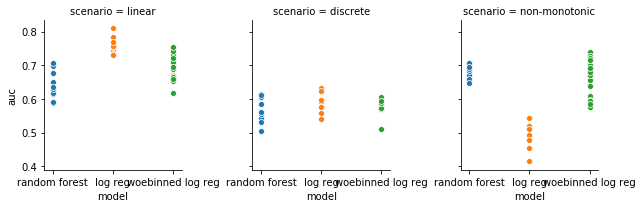

<IPython.core.display.Javascript object>

In [62]:
g = sns.FacetGrid(data=pd.DataFrame(results), col="scenario", hue="model")
g.map(sns.scatterplot, "model", "auc")

In [63]:
pd.DataFrame(results).groupby(["scenario", "model"])[["auc"]].mean()

auc
scenario      model                      
discrete      log reg            0.583228
              random forest      0.567403
              woebinned log reg  0.583696
linear        log reg            0.759548
              random forest      0.641075
              woebinned log reg  0.692043
non-monotonic log reg            0.491168
              random forest      0.686082
              woebinned log reg  0.665183

<IPython.core.display.Javascript object>